In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 # OpenCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
# Get data

LABELS = ('PNEUMONIA','NORMAL')
IMG_SIZE=150
def get_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping Images
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train_raw = get_data('C:\\Users\\acer\\Downloads\\Chest_Xray\\chest_xray\\train')
test_raw = get_data('C:\\Users\\acer\\Downloads\\Chest_Xray\\chest_xray\\test')
val_raw = get_data('C:\\Users\\acer\\Downloads\\Chest_Xray\\chest_xray\\val')

<ipython-input-3-910803788d66>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


C:\Users\acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

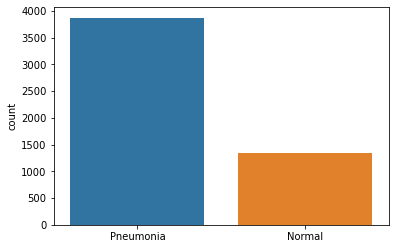

In [5]:
# Training Data
count = []
for i in train_raw:
    if(i[1] == 1):
        count.append("Normal")
    else:
        count.append('Pneumonia')

sns.countplot(count)

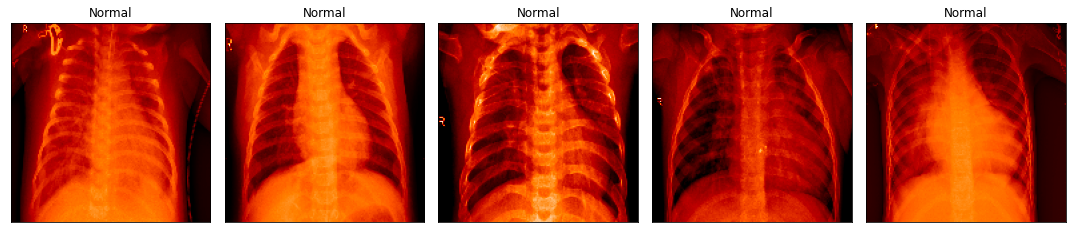

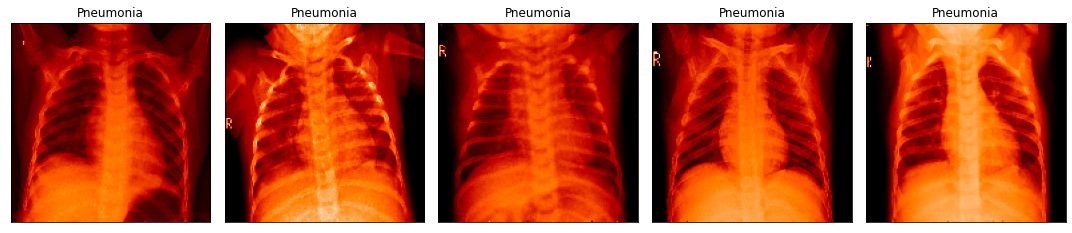

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (train_raw[i][1] == 1):
        img = train_raw[i][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (train_raw[i][1] == 0):
        img = train_raw[-(i+1)][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

In [7]:
#Splitting data

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for image, label in train_raw:
    X_train.append(image)
    y_train.append(label)
    
for image, label in val_raw:
    X_val.append(image)
    y_val.append(label)
    
for image, label in test_raw:
    X_test.append(image)
    y_test.append(label)

In [8]:
# Normalize the data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [9]:
# Resize data for deep learning 
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [11]:
np.random.seed = 18
NUM_EPOCHS = 18

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (160,160,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 64)        0

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

history = model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                    epochs = NUM_EPOCHS,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks = [learning_rate_reduction]
                   )

Epoch 1/18
163/163 [==============================] - 334s 2s/step - loss: 0.0979 - accuracy: 0.9670 - val_loss: 1.4560 - val_accuracy: 0.5000
Epoch 2/18
163/163 [==============================] - 214s 1s/step - loss: 0.0933 - accuracy: 0.9680 - val_loss: 1.8132 - val_accuracy: 0.5625
Epoch 3/18
163/163 [==============================] - 217s 1s/step - loss: 0.1046 - accuracy: 0.9663 - val_loss: 1.6888 - val_accuracy: 0.5000
Epoch 4/18
163/163 [==============================] - 219s 1s/step - loss: 0.0996 - accuracy: 0.9622 - val_loss: 1.4253 - val_accuracy: 0.5000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 5/18
163/163 [==============================] - 216s 1s/step - loss: 0.0953 - accuracy: 0.9663 - val_loss: 1.4909 - val_accuracy: 0.5000
Epoch 6/18
163/163 [==============================] - 210s 1s/step - loss: 0.1045 - accuracy: 0.9674 - val_loss: 1.7221 - val_accuracy: 0.5625
Epoch 7/18
163/163 [==============================] - 220s 1s/step - loss: 0.

In [14]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 5s 227ms/step - loss: 0.2925 - accuracy: 0.9119
Loss of the model is -  0.29253244400024414
20/20 [==============================] - 5s 233ms/step - loss: 0.2925 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


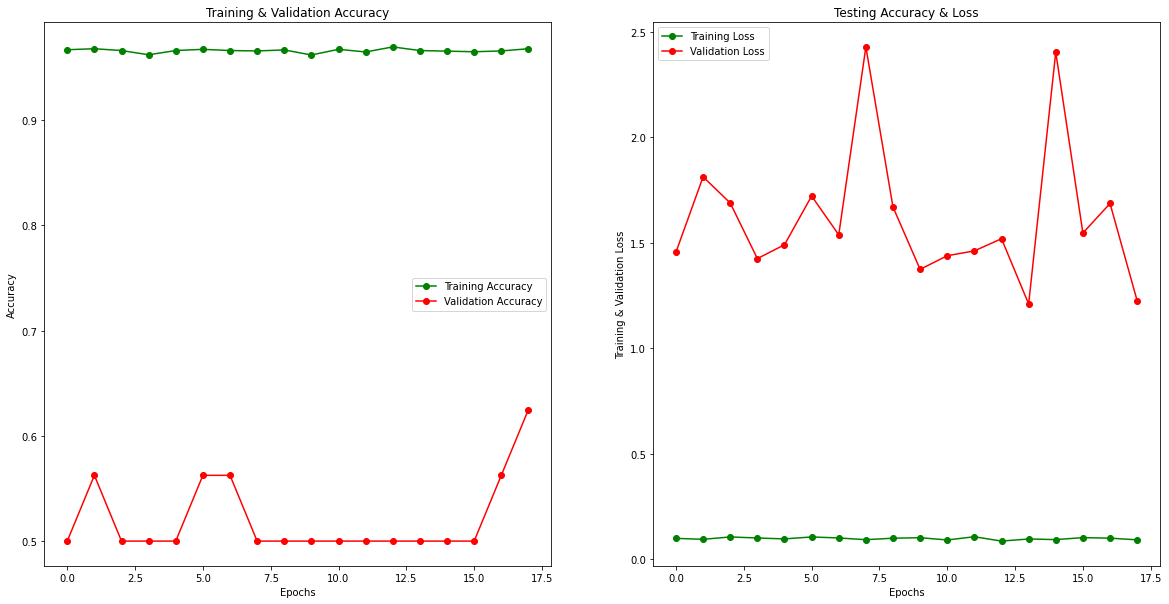

In [15]:
epochs = [i for i in range(NUM_EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
y_preds = model.predict_classes(X_test)
y_preds = y_preds.reshape(1,-1)[0]
y_preds

C:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
# Classification report
print(classification_report(y_test, y_preds, target_names= ['Pneumonia (0)', 'Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.92      0.94      0.93       390
   Normal (1)       0.90      0.86      0.88       234

     accuracy                           0.91       624
    macro avg       0.91      0.90      0.91       624
 weighted avg       0.91      0.91      0.91       624



<AxesSubplot:>

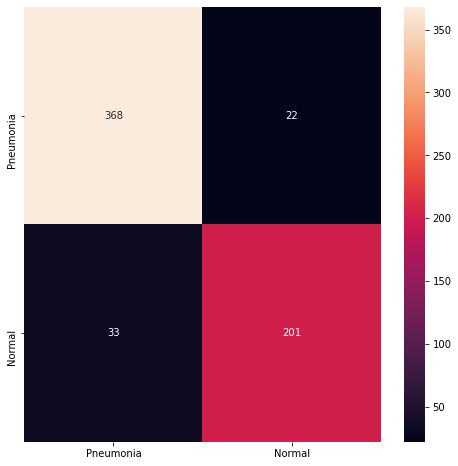

In [18]:
# Confusion matrix
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='', xticklabels=['Pneumonia','Normal'], yticklabels=['Pneumonia','Normal'])

In [19]:
correct = np.nonzero(y_preds == y_test)[0]
incorrect = np.nonzero(y_preds != y_test)[0]
correct[:10], incorrect[:10]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64),
 array([  8,  20,  48,  53,  54,  65,  75,  83,  88, 122], dtype=int64))

In [20]:
def plot_preds(correct, incorrect, X_test, y_test, n=4, corr=True):
    """
    Prints correct or incorrect predictions.
    """
    labels=['pneumonia', 'normal']
    
    plt.figure(figsize=(10,15))
    
    # Correct
    if corr:
        print("Correct predictions:\n")
        i=0
        for c in correct[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[c])
            plt.title(f'Predicted: {labels[y_preds[c]]}, Actual: {labels[y_test[c]]}')
            plt.tight_layout()
            i+=1

    # Incorrect
    else:
        print("Incorrect predictions:\n")
        i=0
        for inc in incorrect[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[inc])
            plt.title(f'Predicted: {labels[y_preds[inc]]}, Actual: {labels[y_test[inc]]}')
            plt.tight_layout()
            i+=1

Correct predictions:



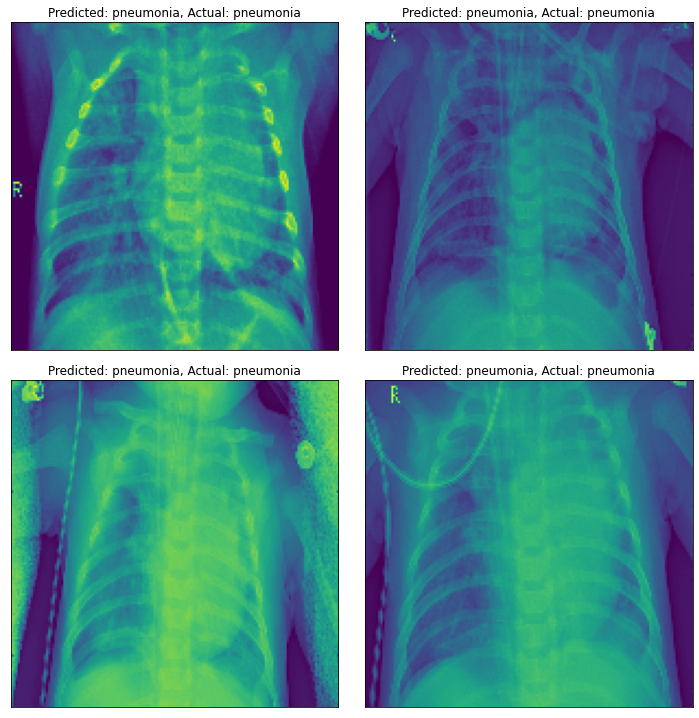

In [21]:
plot_preds(correct, incorrect, X_test, y_test)

Incorrect predictions:



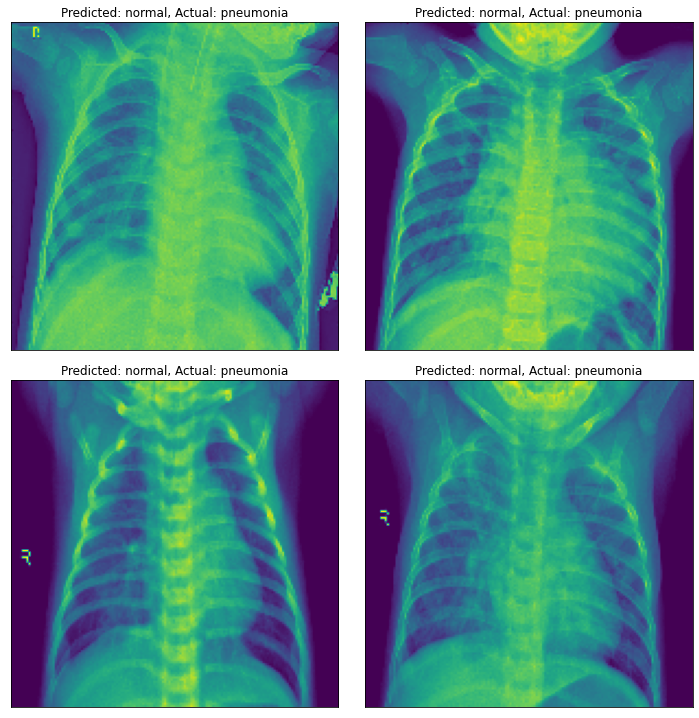

In [22]:
plot_preds(correct, incorrect, X_test, y_test, corr=False)